In [1]:
import numpy as np
import random
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import hnswlib

In [2]:
# --- FUNCTIONS START ---

In [130]:
def generate_points(n, std, dim):
    # Set the seed for reproducibility
    np.random.seed(42)
    
    sqrt_n = int(np.sqrt(n))
    
    # Generate the uniform points
    uniform_points = np.random.uniform(0, 2, (sqrt_n, dim))

    # Generate the normal points_
    normal_points = np.zeros((sqrt_n, sqrt_n, 1))
    for i in range(sqrt_n):
        for j in range(sqrt_n):
            normal_points[i,j] = np.random.normal(uniform_points[i], std, dim)
    
    return uniform_points, normal_points

In [131]:
def plot_points_1d(uniform_points, normal_points, bins):
    # Flatten the arrays for plotting
    uniform_points = uniform_points.flatten()
    normal_points = normal_points.flatten()

    # Plotting the points
    plt.figure(figsize=(16, 4))

    # Plotting the histogram
    plt.subplot(1, 2, 2)
    plt.hist(normal_points, bins=100)
    plt.scatter(uniform_points, np.zeros_like(uniform_points), color='r', label='klasterio centras')
    plt.xlabel('x')
    plt.ylabel('Dažnis')
    plt.title(f'n={str(len(normal_points))}')
    plt.legend(loc="upper right")
    
    plt.tight_layout()
    plt.show()

In [71]:
# ALGO PARAMS - https://github.com/nmslib/hnswlib/blob/master/ALGO_PARAMS.md

def create_index_and_get_recall(data, space, dim, n, ef_construction, M, random_seed):
    p = hnswlib.Index(space=space, dim=dim)

    # Initializing index - the maximum number of elements should be known beforehand
    # ef_construction - the parameter has the same meaning as ef, but controls the index_time/index_accuracy. 
    # Bigger ef_construction leads to longer construction, but better index quality. 
    # At some point, increasing ef_construction does not improve the quality of the index. 
    # One way to check if the selection of ef_construction was ok is to measure a recall for M nearest neighbor 
    # search when ef =ef_construction: if the recall is lower than 0.9, than there is room for improvement.?
    p.init_index(max_elements=n, ef_construction=ef_construction, M=M, random_seed=random_seed)

    # Element insertion
    p.add_items(data)

    # ef - the size of the dynamic list for the nearest neighbors (used during the search). 
    # Higher ef leads to more accurate but slower search. ef cannot be set lower than the number of queried nearest 
    # neighbors k. The value ef of can be anything between k and the size of the dataset.
    p.set_ef(ef_construction)  # ef should always be > k

    # Query the elements for themselves
    labels, distances = p.knn_query(data, k=1)
    
    # Measure recall
    # TODO - check
    recall = np.mean(labels.reshape(-1) == np.arange(len(data)))

    return recall

In [72]:
# --- FUNCTIONS END ---

In [132]:
ns = [100, 2_500, 10_000, 250_000, 1_000_000]

In [148]:
N = 10

In [134]:
ef_constructions = [2,4,8,16,32,64,128]

In [135]:
space = 'l2'
random_seed = 42

In [136]:
# --- 1D START ---

In [137]:
dim = 1

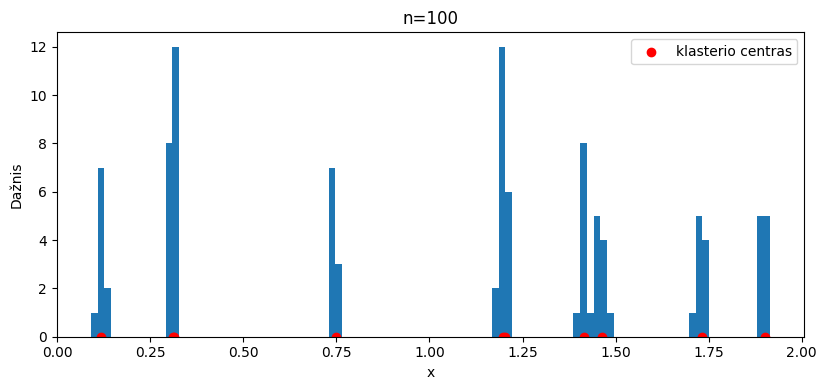

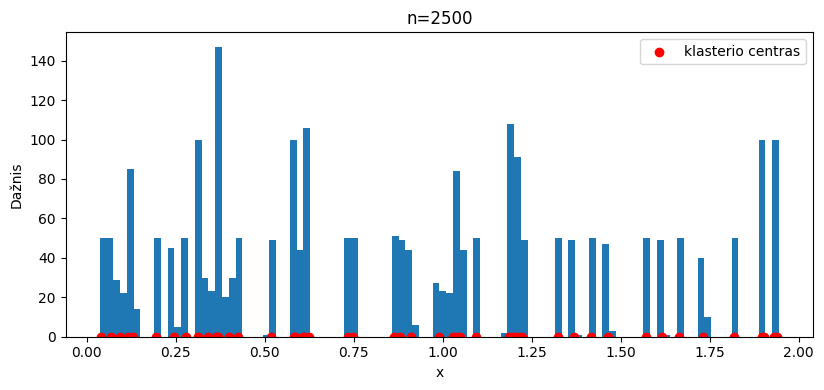

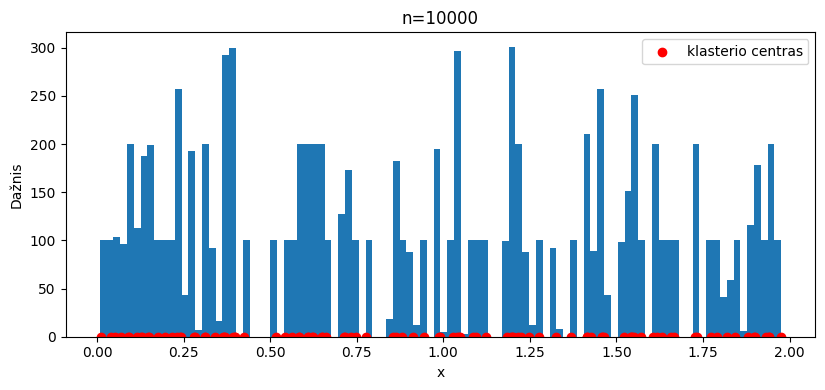

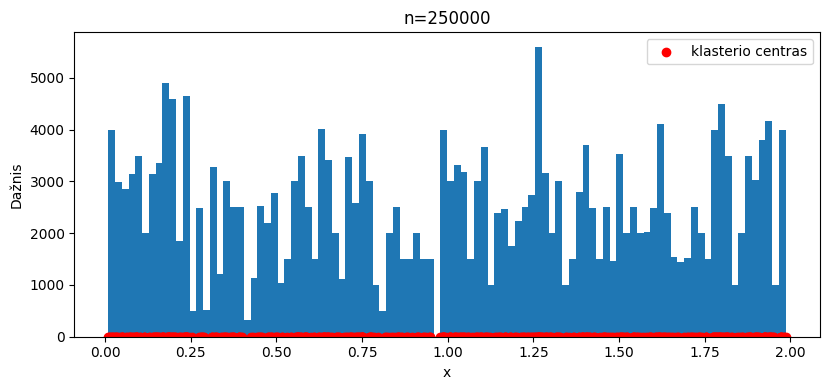

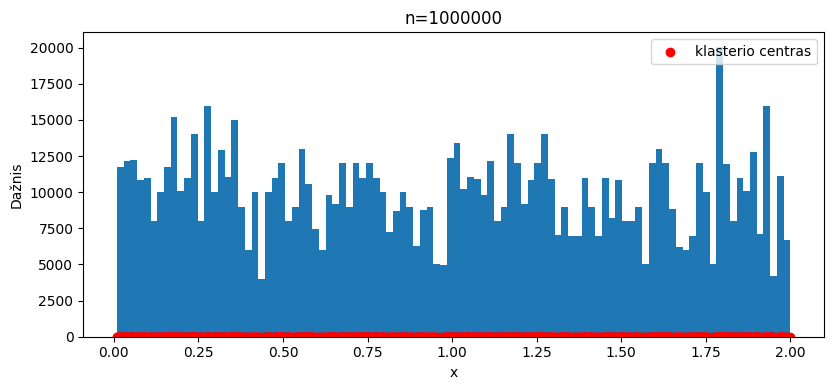

In [150]:
results_df_1d = pd.DataFrame(columns = ['n', 'ef_construction', 'M', 'jautrumas'])

for n in ns:
    sqrt_n = int(np.sqrt(n))
    std = 1/(10*sqrt_n)
    uniform_points, normal_points = generate_points(n, std, dim)
    plot_points_1d(uniform_points, normal_points, bins=n)
    np.random.shuffle(normal_points)
    
    data = normal_points
    ids = np.arange(n)
    
    data_reshaped = np.reshape(data, (-1, dim))
    
    for ec in ef_constructions:
        recalls = []
        for i in range(N):
            recall = create_index_and_get_recall(data_reshaped, space, dim, n, ec, ec, random_seed)
            recalls.append(recall)
        avg_recall = sum(recalls)/len(recalls)
        
        results_df_1d.loc[len(results_df_1d.index)] = [n, ec, ec, avg_recall] 

In [151]:
results_df_1d

,n,ef_construction,M,jautrumas
0,100.0,2.0,2.0,0.872000
1,100.0,4.0,4.0,0.985000
2,100.0,8.0,8.0,0.967000
3,100.0,16.0,16.0,0.989000
4,100.0,32.0,32.0,1.000000
5,100.0,64.0,64.0,1.000000
6,100.0,128.0,128.0,1.000000
7,2500.0,2.0,2.0,0.544200
8,2500.0,4.0,4.0,0.828520
9,2500.0,8.0,8.0,0.886040


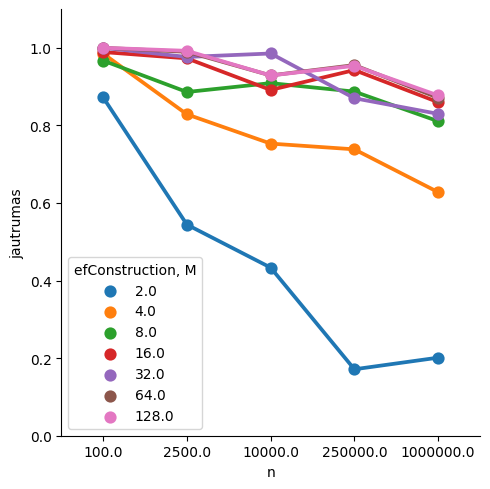

In [153]:
p = sns.catplot(data=results_df_1d, x='n', y="jautrumas", hue='ef_construction', kind='point', legend=False)
plt.legend(title='efConstruction, M')
plt.ylim(0, 1.1)
plt.show()

In [18]:
# --- 1D END ---

In [19]:
# --- 2D START ---

In [162]:
def generate_2d(n):
    sqrt_n = int(np.sqrt(n))
    std = 1/(10*sqrt_n)
    # Generate the uniform points
    uniform_points_2d = np.random.uniform(0, 2, (sqrt_n, 2))

    # Generate the normal points
    normal_points_2d = np.zeros((sqrt_n, sqrt_n, 2))
    for i in range(sqrt_n):
        for j in range(sqrt_n):
            normal_points_2d[i, j, :] = np.random.normal(uniform_points_2d[i], std, 2)

    return uniform_points_2d, normal_points_2d
            

def plot_2d(normal_points_2d, uniform_points_2d):
    plt.scatter(normal_points_2d[:, :, 0].flatten(), normal_points_2d[:, :, 1].flatten(), c='b', label='Normaliai pasiskirstę taškai', s=10)
    plt.scatter(uniform_points_2d[:, 0], uniform_points_2d[:, 1], c='r', label='Klasterio centras', s=4)
    plt.title(f'n={str(len(normal_points_2d)**2)}')
    plt.legend()
    plt.show()
    

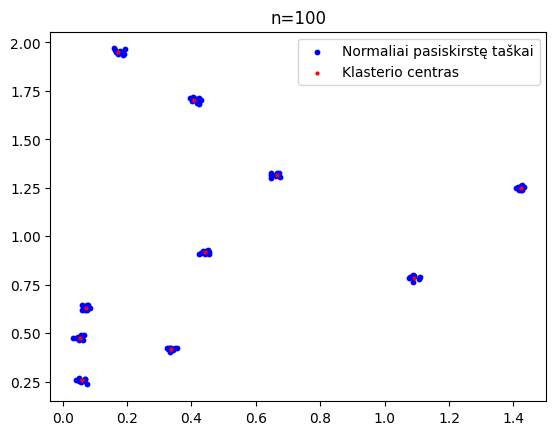

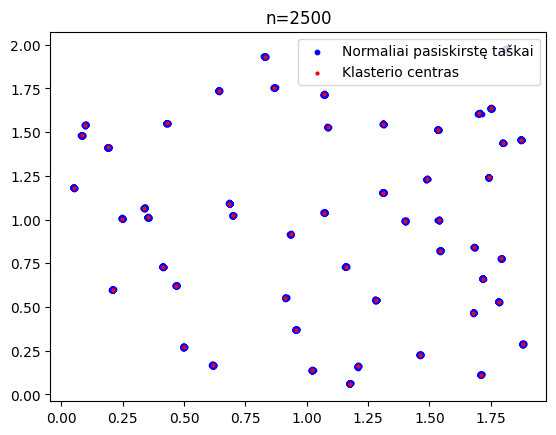

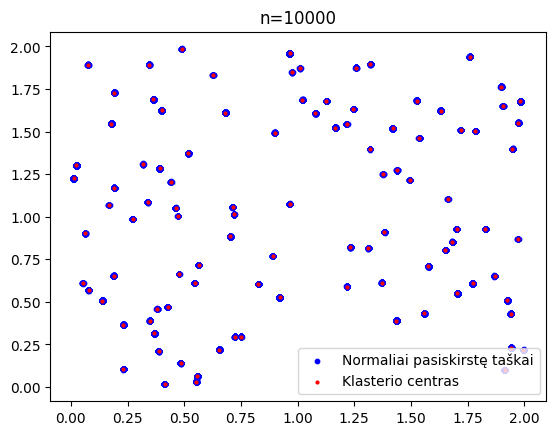

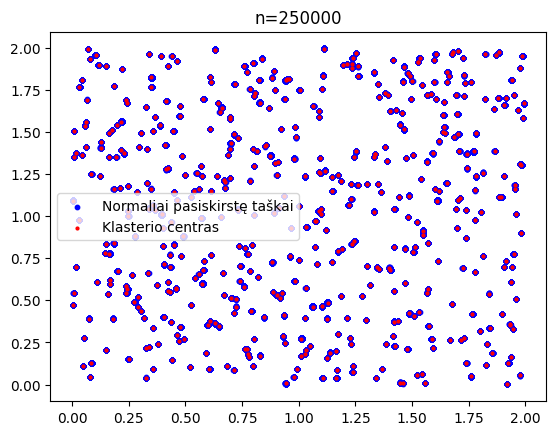

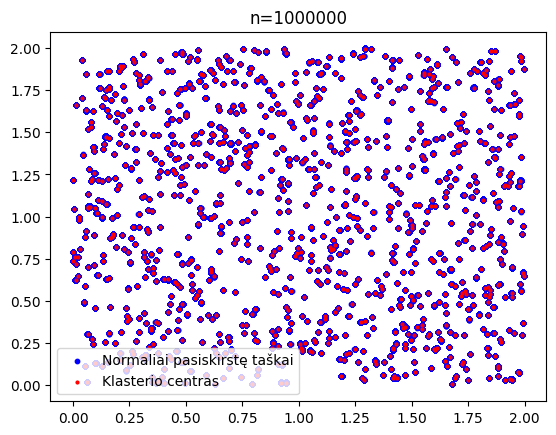

In [163]:
for n in ns:
    uniform_points_2d, normal_points_2d = generate_2d(n)
    plot_2d(normal_points_2d, uniform_points_2d)

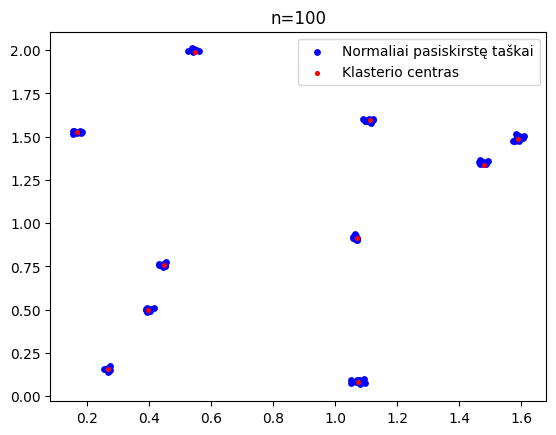

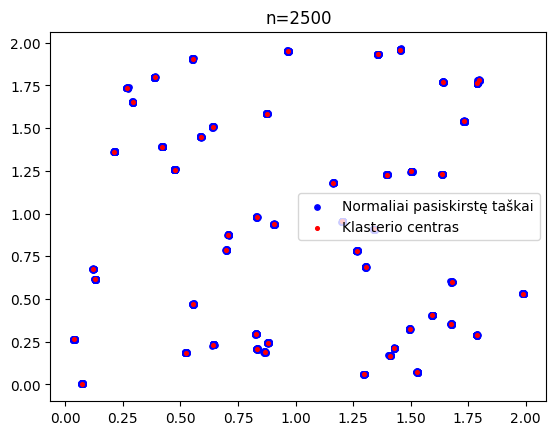

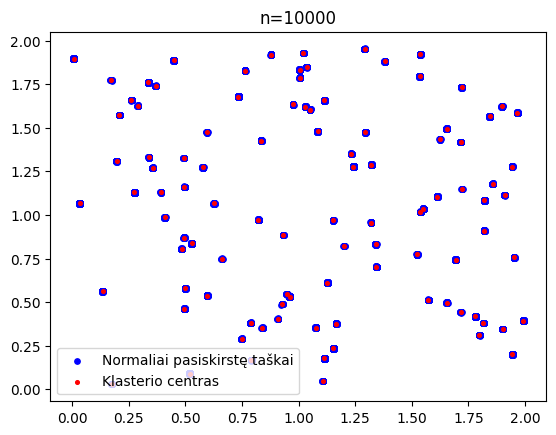

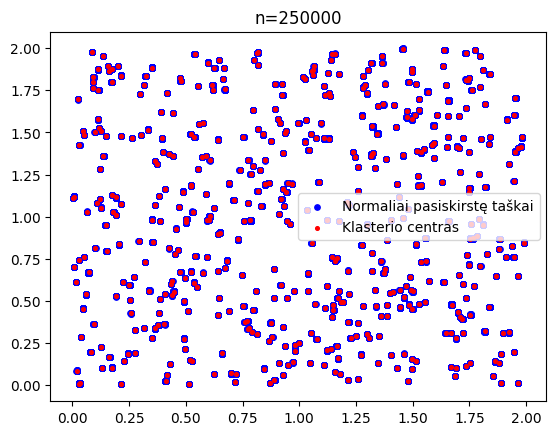

/Users/brigitap/opt/anaconda3/envs/hnswpy/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


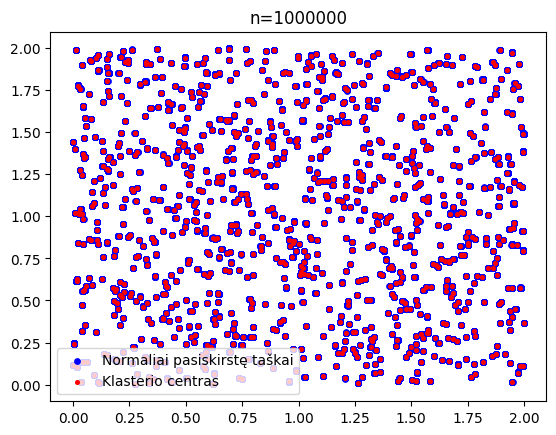

In [155]:
results_df_2d = pd.DataFrame(columns = ['n', 'ef_construction', 'M', 'jautrumas'])

for n in ns:
    uniform_points_2d, normal_points_2d = generate_2d(n)
    plot_2d(normal_points_2d, uniform_points_2d)
    
    data_reshaped = normal_points_2d.reshape(-1, 2)
        
    for ec in ef_constructions:
        recalls = []
        for i in range(N):
            recall = create_index_and_get_recall(data_reshaped, space, 2, n, ec, ec, random_seed)
            recalls.append(recall)
            
        avg_recall = sum(recalls)/len(recalls)
        results_df_2d.loc[len(results_df_2d.index)] = [n, ec, ec, avg_recall] 

In [156]:
results_df_2d

,n,ef_construction,M,jautrumas
0,100.0,2.0,2.0,0.737000
1,100.0,4.0,4.0,0.931000
2,100.0,8.0,8.0,0.987000
3,100.0,16.0,16.0,0.992000
4,100.0,32.0,32.0,1.000000
5,100.0,64.0,64.0,1.000000
6,100.0,128.0,128.0,1.000000
7,2500.0,2.0,2.0,0.396320
8,2500.0,4.0,4.0,0.749440
9,2500.0,8.0,8.0,0.824880


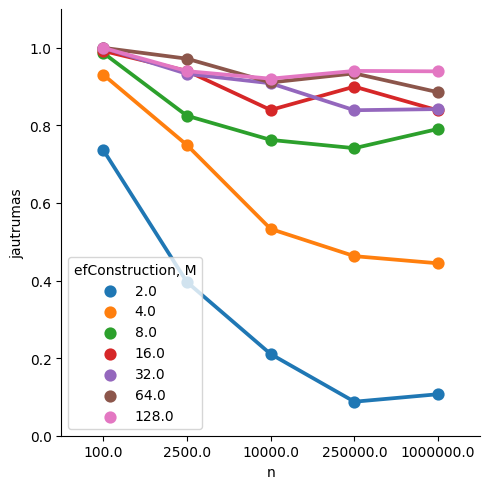

In [157]:
p = sns.catplot(data=results_df_2d, x='n', y="jautrumas", hue='ef_construction', kind='point', legend=False)
plt.legend(title='efConstruction, M')
plt.ylim(0, 1.1)
plt.show()